In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.stats import binned_statistic_2d
from scipy.stats import binned_statistic

import sys
sys.path.append('./functions')

from box_io import load_beeframe_meta_from_box
from comb_loading import get_organized_colony_names
from comb_loading import load_colony_comb    
from comb_loading import create_colonies_summary
from comb_loading import visualize_colony
from mask_processing import get_distance_to_class
from mask_processing import get_interior_mask, dilate_class

In [4]:
comb_class = 2
wood_class = 1

load_meta_from_file = True
if load_meta_from_file:
    meta_file = "/home/golden/Dropbox/bee-comb/img_to_text_df_TOEDIT.csv"
    # MLS file path:
    meta_file = "/Users/michaelsmith/Library/CloudStorage/Box-Box/3D_nest_2021/img_to_text_df_TOEDIT.csv"
    beeframe_meta = pd.read_csv(meta_file)

In [5]:
colony_names = get_organized_colony_names(beeframe_meta)

colony_type_SH = "SH"
colony_type_DD = "DD"
max_week = 12

masks_folder_root = "/home/golden/kenya_drones/comb-detection/nest_photos"
# MLS path: 
masks_folder_root = "/Users/michaelsmith/Library/CloudStorage/Box-Box/3D_nest_2021/nest_photos"

colonies = []

for colony_name in colony_names:
    
    masks_folder_name = "warped_masks" # MLS - Should this be something different? Changed to: "warped_masks"
    colony = load_colony_comb(beeframe_meta, colony_name, 
                              masks_folder_root, masks_folder_name,
                              combine_ab=True, mirror_b=True
                             )
    if colony is None:
        print(f"skipping colony {colony_name}")
        continue
    # Sometimes there is a thin layer of false wood on comb edge
    # try to clean this up
    for day_ind, day in enumerate(colony):
        for frame_ind, frame in enumerate(day):
            colony[day_ind, frame_ind] = dilate_class(frame, comb_class, 4)
    if len(colony) > max_week:
        colony = colony[:max_week]
    print(f"loaded colony {colony_name} ({len(colony)} weeks sorted.)")
    colonies.append({"colony": colony, "type": colony_name[:2], "name": colony_name})

No valid info for frame 1, CC1, 20210811.
returning None
Colony is missing frame info. Returning day until this point.
loaded colony CC1 (1 weeks sorted.)
No valid info for frame 1, CC2, 20210811.
returning None
Colony is missing frame info. Returning day until this point.
loaded colony CC2 (1 weeks sorted.)
No valid info for frame 1, CC5, 20210811.
returning None
Colony is missing frame info. Returning day until this point.
loaded colony CC5 (1 weeks sorted.)
No valid info for frame 1, CC6, 20210811.
returning None
Colony is missing frame info. Returning day until this point.
loaded colony CC6 (1 weeks sorted.)
No valid info for frame 1, CC7, 20210811.
returning None
Colony is missing frame info. Returning day until this point.
loaded colony CC7 (1 weeks sorted.)
loaded colony DD1 (7 weeks sorted.)
loaded colony DD2 (6 weeks sorted.)
loaded colony DD4 (6 weeks sorted.)
loaded colony DD5 (7 weeks sorted.)
No valid info for frame 1, DD6, 20210728.
returning None
Colony is missing frame 

In [6]:
save = False
save_folder = "/home/golden/Dropbox/bee-comb/plots"
# MLS path: 
save_folder = "/Users/michaelsmith/Library/CloudStorage/Box-Box/3D_nest_2021/plots"

os.makedirs(save_folder, exist_ok=True)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

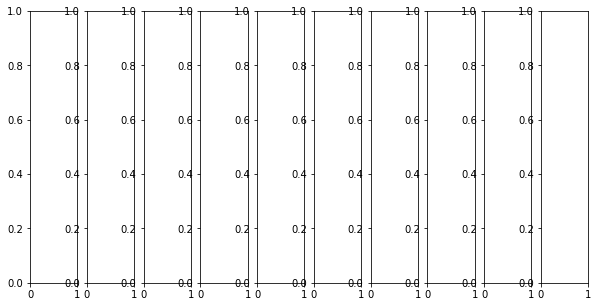

In [7]:

for colony_dict in colonies[:]:

    fig = visualize_colony(colony_dict['colony'], 
                          colony_name=colony_dict['name'],
                          figsize=(10,5)
                          )
    filename = f"whole_colony_{colony_dict['name']}.png"
    if save:
        fig.savefig(os.path.join(save_folder, filename),
                   dpi=300, bbox_inches='tight')

In [45]:
interior_mask = get_interior_mask(colonies[0]['colony'][0][0])
num_interior_pixels = np.sum(interior_mask)
frame_contents = create_colonies_summary(colonies, comb_class, wood_class,
                                         num_interior_pixels)

mean wood range: 0.2752467616153741, 0.3092145103840136
mean wood range: 0.28015109706723995, 0.2922229944317


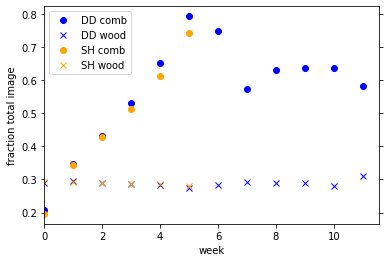

In [46]:
mean_comb = frame_contents.groupby(['type', 'week'])['comb_fraction'].mean()
mean_wood = frame_contents.groupby(['type', 'week'])['wood_fraction'].mean()
for exp_type in ["DD", "SH"]:
    if exp_type == "DD":
        color = 'b'
    elif exp_type == "SH":
        color = 'orange'
    
    plt.plot(mean_comb[exp_type], 'o', c=color, label=f"{exp_type} comb")
    plt.gca().set_xlim([0, None])
    plt.plot(mean_wood[exp_type], 'x', c=color, label=f"{exp_type} wood")
    plt.gca().yaxis.set_ticks_position('both')
    plt.legend()
    plt.xlabel("week")
    plt.ylabel("fraction total image")
    
    print(f"mean wood range: {mean_wood[exp_type].min()}, {mean_wood[exp_type].max()}")
    
    if save:
        filename = f"average_wood_and_comb_area_by_week_by_condition.png"
        plt.savefig(os.path.join(save_folder, filename),
                   dpi=300, bbox_inches='tight')

In [53]:
for exp_type in gb_mean.index.unique(level=0):
    print(exp_type)

CC
DD
SH


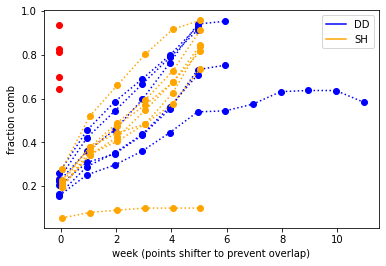

In [54]:
columns = ['type', 'colony', 'week']
plot_shift = .05
gb_mean = frame_contents.groupby(columns)['comb_fraction'].mean()
for exp_type in gb_mean.index.unique(level=0):
    exp_colonies = gb_mean[exp_type]
    if exp_type == "DD":
        color = 'b'
        ps = -1 * plot_shift
    elif exp_type == "CC":
        color = 'red'
        ps = -1 * plot_shift
    elif exp_type == "SH":
        color = 'orange'
        ps =  plot_shift
    for colony_name in exp_colonies.index.unique(level=0):
        mean_comb_weeks = exp_colonies[colony_name]
        plt.plot(np.arange(len(mean_comb_weeks)) + ps,
                 mean_comb_weeks, 
                 "o", c=color
                )
        plt.plot(np.arange(len(mean_comb_weeks)) + ps,
                 mean_comb_weeks, 
                 ":", c=color
                )
plt.xlabel("week (points shifter to prevent overlap)")
plt.ylabel("fraction comb")
legend_elements = [Line2D([0], [0], color='b', label='DD'),
                   Line2D([0], [0], color='orange', label='SH'),
                   ]
plt.legend(handles=legend_elements)

if save:
        filename = f"average_wood_and_comb_area_by_colony_by_week_by_condition.png"
        plt.savefig(os.path.join(save_folder, filename),
                   dpi=300, bbox_inches='tight')

mean wood range: 0.2752467616153741, 0.3092145103840136
mean wood range: 0.278736491525997, 0.29314558979808714


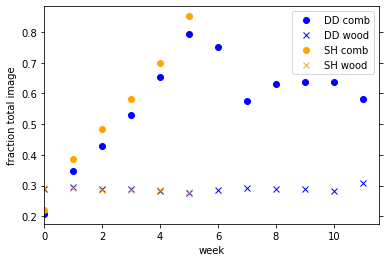

In [55]:
frame_contents_not_SH1 = frame_contents.loc[frame_contents['colony']!="SH1"]
mean_comb = frame_contents_not_SH1.groupby(['type', 'week'])['comb_fraction'].mean()
mean_wood = frame_contents_not_SH1.groupby(['type', 'week'])['wood_fraction'].mean()
for exp_type in ["DD", "SH"]:
    if exp_type == "DD":
        color = 'b'
    elif exp_type == "SH":
        color = 'orange'
    
    plt.plot(mean_comb[exp_type], 'o', c=color, label=f"{exp_type} comb")
    plt.gca().set_xlim([0, None])
    plt.plot(mean_wood[exp_type], 'x', c=color, label=f"{exp_type} wood")
    plt.gca().yaxis.set_ticks_position('both')
    plt.legend()
    plt.xlabel("week")
    plt.ylabel("fraction total image")
    
    print(f"mean wood range: {mean_wood[exp_type].min()}, {mean_wood[exp_type].max()}")
    
    if save:
        filename = f"average_wood_and_comb_area_by_week_by_condition_excluding_SH1.png"
        plt.savefig(os.path.join(save_folder, filename),
                   dpi=300, bbox_inches='tight')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

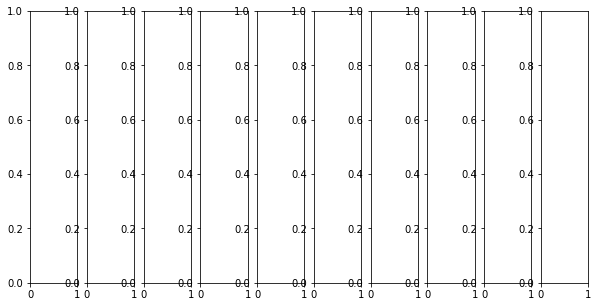

In [56]:
# JUST looking at colony DD6 (have 12 weeks for that one)


for colony_dict in colonies[:]:

    fig = visualize_colony(colony_dict['colony'], 
                          colony_name=colony_dict['name'],
                          figsize=(10,5)
                          )
    filename = f"whole_colony_{colony_dict['name']}.png"
    if save:
        fig.savefig(os.path.join(save_folder, filename),
                   dpi=300, bbox_inches='tight')

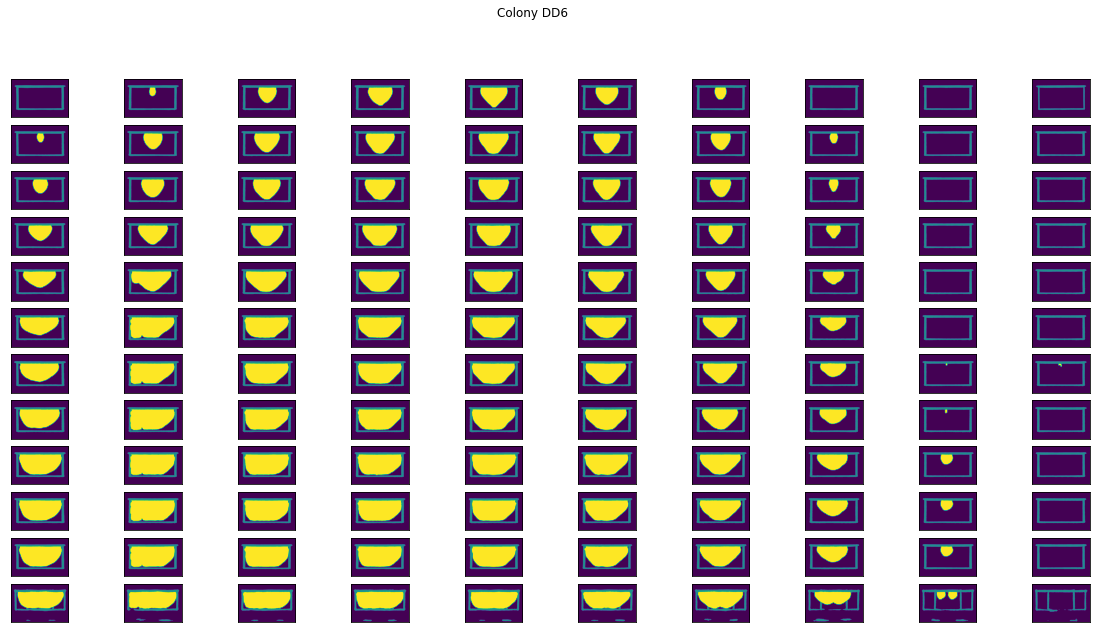

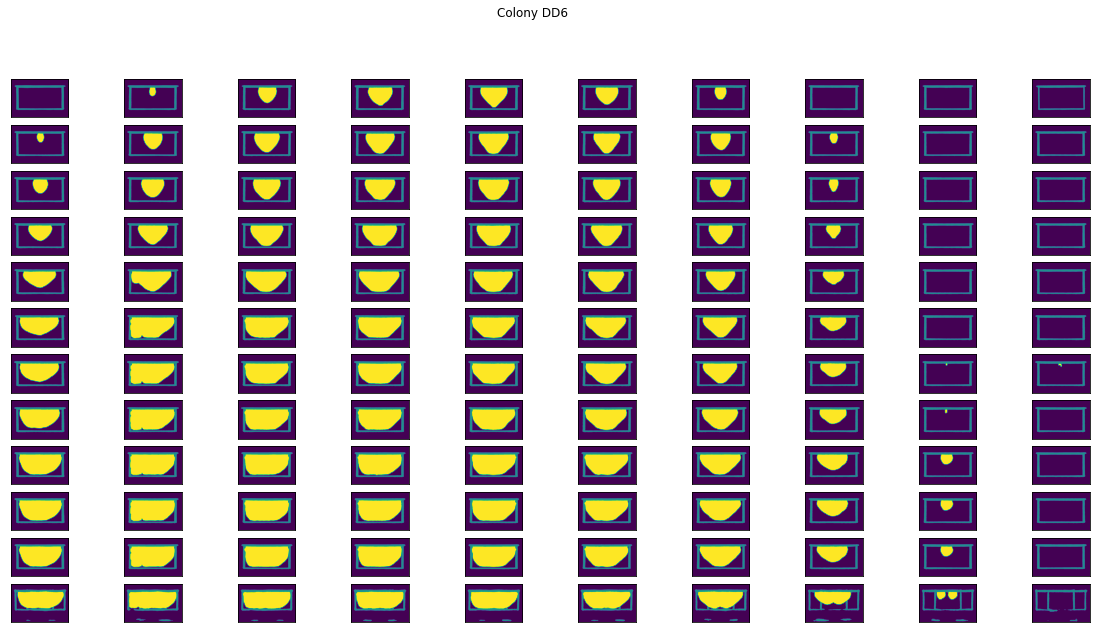

In [58]:
# DD6 is the 4th of the colonies, 9th if you include CC's
one_colony = 9

visualize_colony(colonies[one_colony]['colony'], 
                 figsize=(20, 10), 
                 colony_name=colonies[one_colony]['name'])

In [ ]:
# NEXT STEP: PLOT PIXELS OF COMB PER FRAME OVER TIME... 

In [59]:
frame_contents_not_SH1

,colony,week,frame,type,wood_pixels,comb_pixels,wood_fraction,comb_fraction
0,CC1,0,0,CC,54141,0,0.289124,0.000000
1,CC1,0,1,CC,54810,115790,0.292696,0.618341
2,CC1,0,2,CC,53654,151485,0.286523,0.808960
3,CC1,0,3,CC,54150,167193,0.289172,0.892844
4,CC1,0,4,CC,51331,177013,0.274118,0.945284
...,...,...,...,...,...,...,...,...
905,SH7,5,5,SH,52835,179576,0.282149,0.958971
906,SH7,5,6,SH,52321,180720,0.279404,0.965080
907,SH7,5,7,SH,51221,182679,0.273530,0.975542
908,SH7,5,8,SH,50244,175861,0.268313,0.939132


In [60]:
frame_contents_not_SH1[frame_contents_not_SH1['colony']=='DD6']

,colony,week,frame,type,wood_pixels,comb_pixels,wood_fraction,comb_fraction
310,DD6,0,0,DD,56672,0,0.302640,0.000000
311,DD6,0,1,DD,56768,10116,0.303152,0.054021
312,DD6,0,2,DD,56765,47249,0.303136,0.252319
313,DD6,0,3,DD,57228,70081,0.305609,0.374246
314,DD6,0,4,DD,57966,79822,0.309550,0.426265
...,...,...,...,...,...,...,...,...
425,DD6,11,5,DD,56998,137939,0.304381,0.736621
426,DD6,11,6,DD,57734,123812,0.308311,0.661181
427,DD6,11,7,DD,56418,79004,0.301283,0.421897
428,DD6,11,8,DD,65002,23460,0.347124,0.125281


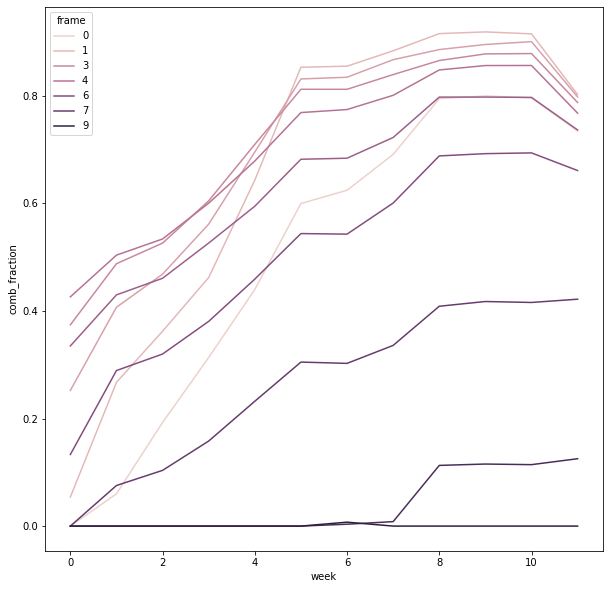

In [63]:
plt.figure(figsize=(10,10))

sns.lineplot(x='week', y='comb_fraction',
             hue='frame',
             data=frame_contents_not_SH1[frame_contents_not_SH1['colony']=='DD6'])

# plt.xlim(4.5,6.5)

In [65]:
DD6 = frame_contents_not_SH1[frame_contents_not_SH1['colony']=='DD6']

In [66]:
DD6

,colony,week,frame,type,wood_pixels,comb_pixels,wood_fraction,comb_fraction
310,DD6,0,0,DD,56672,0,0.302640,0.000000
311,DD6,0,1,DD,56768,10116,0.303152,0.054021
312,DD6,0,2,DD,56765,47249,0.303136,0.252319
313,DD6,0,3,DD,57228,70081,0.305609,0.374246
314,DD6,0,4,DD,57966,79822,0.309550,0.426265
...,...,...,...,...,...,...,...,...
425,DD6,11,5,DD,56998,137939,0.304381,0.736621
426,DD6,11,6,DD,57734,123812,0.308311,0.661181
427,DD6,11,7,DD,56418,79004,0.301283,0.421897
428,DD6,11,8,DD,65002,23460,0.347124,0.125281


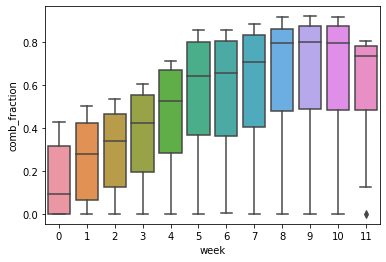

In [89]:
sns.boxplot(x='week', y='comb_fraction', data=DD6)

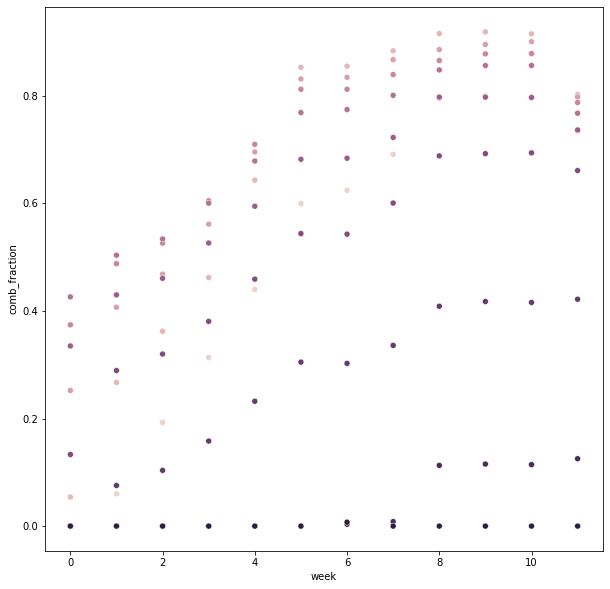

In [78]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='week', y='comb_fraction', hue='frame', data=DD6, legend=False)

In [134]:
DD6[DD6['week'].isin([8,9,10])]

,colony,week,frame,type,wood_pixels,comb_pixels,wood_fraction,comb_fraction
390,DD6,8,0,DD,54226,148858,0.289578,0.794931
391,DD6,8,1,DD,52450,171487,0.280093,0.915774
392,DD6,8,2,DD,54214,165931,0.289513,0.886104
393,DD6,8,3,DD,53631,162113,0.286400,0.865715
394,DD6,8,4,DD,54218,158833,0.289535,0.848200
395,DD6,8,5,DD,53858,149380,0.287612,0.797719
396,DD6,8,6,DD,54670,128904,0.291949,0.688373
397,DD6,8,7,DD,54219,76556,0.289540,0.408824
398,DD6,8,8,DD,54400,21131,0.290507,0.112844
399,DD6,8,9,DD,54825,0,0.292776,0.000000


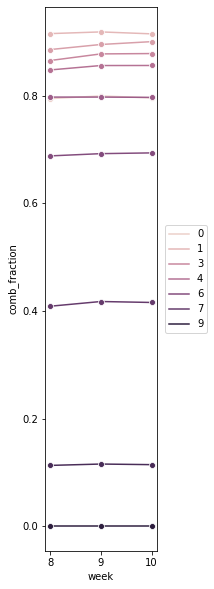

In [133]:
plt.figure(figsize=(2,10))
sns.lineplot(x='week', y='comb_fraction', hue='frame', data=DD6[DD6['week'].isin([8,9,10])], 
             marker='o', legend=True)

plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), ncol=1)


In [ ]:
# FROM COMB_LOADING: 

def visualize_colony(colony, figsize=(20, 10), max_class=2,
                     colony_name=None):
    """ Show all frames in colony in grid.
    
    Args: 
        colony: (WxFxHxW) array
        figsize: size to draw figure
        max_class: number of classes to display in frames
        colony_name: name of the colony
        
    Returns:
        figure (plots figure)
    """
    num_weeks = colony.shape[0]
    num_frames = colony.shape[1]
    fig, axs = plt.subplots(num_weeks, num_frames, figsize=figsize)
    for week, week_frames in enumerate(colony):
        for frame_ind, frame in enumerate(week_frames):
            axs[week, frame_ind].imshow(frame, vmin=0, vmax=max_class)
            axs[week, frame_ind].get_xaxis().set_visible(False)
            axs[week, frame_ind].get_yaxis().set_visible(False)
            axs[week, frame_ind].set_ylabel(f"week {week}")
            axs[week, frame_ind].set_xlabel(f"frame {frame_ind}")

    if colony_name:
        _ = fig.suptitle(f"Colony {colony_name}")
        
    return fig